## Libraries

In [ ]:
import csv
import pandas as pd
from pymongo import MongoClient
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import avg

## Inserting Trimmed Data into MongoDB

In [25]:
# Connect to MongoDB
client = MongoClient("mongodb://localhost:27017/")
db = client["Project"]

# === Trim and load only first 1000 rows of Bike data ===
with open("project_file.csv", "r", encoding="utf-8") as f:
    reader = csv.DictReader(f) 
    BikeData = [row for _, row in zip(range(1000), reader)]
db["Project"].insert_many(BikeData)
print(f"✅ Inserted {len(BikeData)} rows of data")


✅ Inserted 1000 rows of data


## Starting Spark Session

In [26]:
spark = SparkSession.builder.appName("Bike Data Analysis").getOrCreate()

## Loading data from MongoDB via PyMongo

In [27]:
## Read documents, exclude '_id'
BikeData_docs = list(db["Project"].find({}, {"_id": 0}))

# Convert to Spark DataFrames
BikeData = spark.createDataFrame(BikeData_docs)

BikeData.show(10 )

+--------------------+--------------------+----------------------+---------------+-------------------+-----------------+-------------------+-------------------+
|Covered distance (m)|Departure station id|Departure station name|Duration (sec.)|             Return|Return station id|Return station name|         ﻿Departure|
+--------------------+--------------------+----------------------+---------------+-------------------+-----------------+-------------------+-------------------+
|                1885|                 016|       Liisanpuistikko|            499|2021-05-01T00:08:15|              002|    Laivasillankatu|2021-04-30T23:59:54|
|                3359|                 020|     Kaisaniemenpuisto|            984|2021-05-01T00:16:16|              112| Rautatieläisenkatu|2021-04-30T23:59:52|
|                1633|                 004|             Viiskulma|            824|2021-05-01T00:13:40|              033|  Kauppakorkeakoulu|2021-04-30T23:59:52|
|                6459|            

In [28]:
print(BikeData.columns)

['Covered distance (m)', 'Departure station id', 'Departure station name', 'Duration (sec.)', 'Return', 'Return station id', 'Return station name', '\ufeffDeparture']


In [29]:
BikeData.printSchema()


root
 |-- Covered distance (m): string (nullable = true)
 |-- Departure station id: string (nullable = true)
 |-- Departure station name: string (nullable = true)
 |-- Duration (sec.): string (nullable = true)
 |-- Return: string (nullable = true)
 |-- Return station id: string (nullable = true)
 |-- Return station name: string (nullable = true)
 |-- ﻿Departure: string (nullable = true)



In [30]:
# Rename the columns
UpdatedBikeData = BikeData.withColumnRenamed("Covered distance (m)", "CoveredDistance_m") \
                 .withColumnRenamed("Duration (sec.)", "Duration_sec")


In [31]:
UpdatedBikeData.printSchema()

root
 |-- CoveredDistance_m: string (nullable = true)
 |-- Departure station id: string (nullable = true)
 |-- Departure station name: string (nullable = true)
 |-- Duration_sec: string (nullable = true)
 |-- Return: string (nullable = true)
 |-- Return station id: string (nullable = true)
 |-- Return station name: string (nullable = true)
 |-- ﻿Departure: string (nullable = true)



In [ ]:
from pyspark.sql.functions import col

# Change datatype string → integer
UpdatedBikeData = UpdatedBikeData.withColumn("CoveredDistance_m", col("CoveredDistance_m").cast("int")) \
                 .withColumn("Duration_sec", col("Duration_sec").cast("int"))


In [33]:
UpdatedBikeData.printSchema()

root
 |-- CoveredDistance_m: integer (nullable = true)
 |-- Departure station id: string (nullable = true)
 |-- Departure station name: string (nullable = true)
 |-- Duration_sec: integer (nullable = true)
 |-- Return: string (nullable = true)
 |-- Return station id: string (nullable = true)
 |-- Return station name: string (nullable = true)
 |-- ﻿Departure: string (nullable = true)



## Counting the Average Values for Distance and Duration

In [ ]:
data_selected = UpdatedBikeData.select(
    "CoveredDistance_m",
    "Departure station name",
    "Duration_sec"
)

# Calculating averages
df_avg = data_selected.groupBy(
    "Departure station name"
).agg(
    avg("CoveredDistance_m").alias("avg_distance_m"),
    avg("Duration_sec").alias("avg_duration_sec")
).orderBy("avg_distance_m", ascending=False)

# Show 10 longest distance departure stations
df_avg.show(10, truncate=False)


+-----------------------------+-----------------+----------------+
|Departure station name       |avg_distance_m   |avg_duration_sec|
+-----------------------------+-----------------+----------------+
|Pitäjänmäen asema            |7911.0           |1324.0          |
|Agronominkatu                |7274.0           |1596.0          |
|Teljäntie                    |6890.666666666667|2436.0          |
|Haagan tori                  |6836.0           |3671.0          |
|Maarinranta                  |6040.0           |1551.0          |
|Opastinsilta                 |6019.666666666667|2037.0          |
|Herttoniemen kirkko          |5597.0           |1775.0          |
|Aalto-yliopisto (M), Tietotie|5153.5           |1288.0          |
|Maunula                      |5017.0           |1576.0          |
|Luoteisväylä                 |4988.0           |1282.5          |
+-----------------------------+-----------------+----------------+
only showing top 10 rows



## Changing Average Duration from Seconds to Minutes and Rounding the Results

In [ ]:
from pyspark.sql.functions import round, col
from pyspark.sql.types import IntegerType

#Changing "avg_duration_sec" -> "avg_duration_min", and rounding to 2 decimals
df_avg = df_avg.withColumn("avg_duration_min", round(col("avg_duration_sec") / 60, 2)) \
               .drop("avg_duration_sec")

#Rounding average distance to 2 decimals
df_avg = df_avg.withColumn("avg_distance_m", round(col("avg_distance_m"), 2))

In [54]:
df_avg.orderBy("avg_duration_min", ascending=False).show(10, truncate=False)

+----------------------+--------------+----------------+
|Departure station name|avg_distance_m|avg_duration_min|
+----------------------+--------------+----------------+
|Marian sairaala       |1519.0        |147.3           |
|Haagan tori           |6836.0        |61.18           |
|Teljäntie             |6890.67       |40.6            |
|Opastinsilta          |6019.67       |33.95           |
|Laajalahden keskus    |3657.0        |30.03           |
|Herttoniemen kirkko   |5597.0        |29.58           |
|Thalianaukio          |2142.0        |27.93           |
|Viiskulma             |2189.0        |27.19           |
|Agronominkatu         |7274.0        |26.6            |
|Liisanpuistikko       |1258.72       |26.39           |
+----------------------+--------------+----------------+
only showing top 10 rows



## Counting the visit number for departure stations

In [56]:
from pyspark.sql import functions as F

# Laske eniten käytetyt lähtöasemat
most_visited_stations = BikeData.groupBy("Departure station id", "Departure station name") \
    .agg(F.count("*").alias("visit_count")) \
    .orderBy(F.col("visit_count").desc())

# Näytä top 10
most_visited_stations.show(10, truncate=False)


+--------------------+-------------------------------------+-----------+
|Departure station id|Departure station name               |visit_count|
+--------------------+-------------------------------------+-----------+
|016                 |Liisanpuistikko                      |230        |
|541                 |Aalto-yliopisto (M), Korkeakouluaukio|95         |
|137                 |Arabian kauppakeskus                 |75         |
|022                 |Rautatientori / länsi                |75         |
|003                 |Kapteeninpuistikko                   |70         |
|006                 |Hietalahdentori                      |70         |
|005                 |Sepänkatu                            |65         |
|129                 |Pernajantie                          |65         |
|071                 |Hietaniemenkatu                      |65         |
|001                 |Kaivopuisto                          |60         |
+--------------------+-----------------------------

## Visualization 

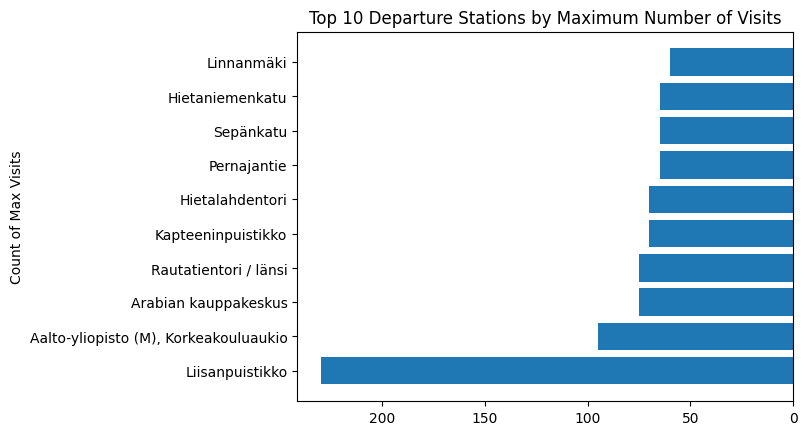

In [ ]:
# Bar Chart for 10 most visited departure stations 

top_df = most_visited_stations.limit(10).toPandas() 

plt.barh(top_df['Departure station name'], top_df['visit_count'])
plt.ylabel("Count of Max Visits")
plt.title("Top 10 Departure Stations by Maximum Number of Visits")
plt.gca().invert_xaxis()  # Reverse x axis
plt.show()
